In [2]:
# Import necessary libraries
import cv2
import numpy as np
import os
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import random
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [4]:
# Initialize MediaPipe holistic model and drawing utilities
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# Define functions for MediaPipe detection and drawing
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert color space
    image.flags.writeable = False
    results = model.process(image)  # Make prediction
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert back to BGR
    return image, results

def draw_styled_landmarks(image, results):
    # # Draw face connections
    # mp_drawing.draw_landmarks(
    #     image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
    #     mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
    #     mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    # )
    # # Draw pose connections
    # mp_drawing.draw_landmarks(
    #     image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
    #     mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
    #     mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
    # )
    # Draw left hand connections
    mp_drawing.draw_landmarks(
        image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
    )
    # Draw right hand connections
    mp_drawing.draw_landmarks(
        image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
    )



In [5]:
def extract_keypoints(results):
    # Exclude pose and face landmarks
    # Left Hand
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]
                         ).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    # Right Hand
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]
                          ).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([left_hand, right_hand])


In [6]:
def normalize_keypoints(sequence):
    # Reshape sequence to (frames, keypoints, coordinates)
    sequence = sequence.reshape(sequence.shape[0], -1, 3)
    normalized_sequence = []
    for frame in sequence:
        # Left Hand
        left_hand = frame[:21, :]
        if np.any(left_hand):
            left_hand_center = left_hand[0, :]  # Wrist
            left_hand = left_hand - left_hand_center  # Center the hand
            hand_size = np.linalg.norm(left_hand[9, :])  # Middle finger MCP
            if hand_size > 0:
                left_hand = left_hand / hand_size  # Scale the hand
            else:
                left_hand = np.zeros((21, 3))
        else:
            left_hand = np.zeros((21, 3))

        # Right Hand
        right_hand = frame[21:, :]
        if np.any(right_hand):
            right_hand_center = right_hand[0, :]  # Wrist
            right_hand = right_hand - right_hand_center  # Center the hand
            hand_size = np.linalg.norm(right_hand[9, :])  # Middle finger MCP
            if hand_size > 0:
                right_hand = right_hand / hand_size  # Scale the hand
            else:
                right_hand = np.zeros((21, 3))
        else:
            right_hand = np.zeros((21, 3))

        # Concatenate normalized keypoints
        frame_normalized = np.concatenate([left_hand, right_hand], axis=0)
        normalized_sequence.append(frame_normalized.flatten())
    return np.array(normalized_sequence)


In [7]:
# Define data augmentation functions
def add_noise(sequence, noise_level=0.05):
    noise = np.random.normal(0, noise_level, sequence.shape)
    return sequence + noise

def scale_sequence(sequence, scale_factor=0.1):
    scaling = np.random.normal(1.0, scale_factor)
    return sequence * scaling

def time_warp(sequence, sigma=0.2):
    from scipy.interpolate import CubicSpline
    num_frames = sequence.shape[0]
    random_warp = np.random.normal(loc=1.0, scale=sigma, size=num_frames)
    cumulative_warp = np.cumsum(random_warp)
    cumulative_warp = (cumulative_warp - cumulative_warp.min()) / (cumulative_warp.max() - cumulative_warp.min()) * (num_frames - 1)
    cs = CubicSpline(np.arange(num_frames), sequence, axis=0)
    warped_sequence = cs(cumulative_warp)
    return warped_sequence

def augment_sequence(sequence):
    augmented_sequence = sequence.copy()
    if np.random.rand() < 0.5:
        augmented_sequence = add_noise(augmented_sequence)
    if np.random.rand() < 0.5:
        augmented_sequence = scale_sequence(augmented_sequence, scale_factor=0.2)  # Wider scaling factor
    if np.random.rand() < 0.5:
        augmented_sequence = time_warp(augmented_sequence)
    return augmented_sequence

In [8]:
# Define paths and actions
DATA_PATH = os.path.join('AUSLAN_Data')

# Actions to detect
actions = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 
                    'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])

# Number of sequences and sequence length
no_sequences = 50
sequence_length = 30

# Label mapping
label_map = {label: num for num, label in enumerate(actions)}

In [9]:
print(label_map)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}


### 1. Data Preprocessing
- Normalization and Centering

- Load and Normalize Data

In [10]:
sequences, labels = [], []
for action in actions:
    for sequence_num in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence_num), f"{frame_num}.npy"))
            # Extract only hand keypoints
            res = res[-(21*3*2):]  # Assuming hand keypoints are at the end
            window.append(res)
        window = np.array(window)
        # Normalize keypoints
        window_normalized = normalize_keypoints(window)
        sequences.append(window_normalized)
        labels.append(label_map[action])


In [11]:
# Convert to numpy arrays
X = np.array(sequences)
y = to_categorical(labels).astype(int)

### 2. Data Augmentation
- Enhanced Augmentation Functions

- Apply Augmentation

In [12]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Augment training data
augmented_sequences = []
augmented_labels = []
for seq, label in zip(X_train, y_train):
    augmented_seq = augment_sequence(seq)
    augmented_sequences.append(augmented_seq)
    augmented_labels.append(label)

# Convert augmented data to numpy arrays
augmented_sequences = np.array(augmented_sequences)
augmented_labels = np.array(augmented_labels)

# Combine original and augmented data
X_train_augmented = np.concatenate((X_train, augmented_sequences), axis=0)
y_train_augmented = np.concatenate((y_train, augmented_labels), axis=0)

# Shuffle the augmented training data
X_train_augmented, y_train_augmented = shuffle(X_train_augmented, y_train_augmented)


### 3. Model Definition

In [13]:
# Compute class weights
from sklearn.utils.class_weight import compute_class_weight
labels_flat = np.argmax(y_train_augmented, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(labels_flat), y=labels_flat)
class_weights = dict(enumerate(class_weights))

In [14]:
# Define the model
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(sequence_length, X.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(actions), activation='softmax'))


c:\Users\khobr\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

### 4. Training with Callbacks

In [20]:
# Define callbacks
callbacks = [
    ModelCheckpoint('best_model_new.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

In [45]:
# Train the model
history = model.fit(
    X_train_augmented, y_train_augmented,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - categorical_accuracy: 0.0734 - loss: 3.2869 - val_categorical_accuracy: 0.0385 - val_loss: 3.2660 - learning_rate: 1.0000e-04
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - categorical_accuracy: 0.2120 - loss: 2.7578 - val_categorical_accuracy: 0.0385 - val_loss: 3.2426 - learning_rate: 1.0000e-04
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - categorical_accuracy: 0.3674 - loss: 2.4617 - val_categorical_accuracy: 0.0615 - val_loss: 3.1608 - learning_rate: 1.0000e-04
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - categorical_accuracy: 0.4840 - loss: 2.1887 - val_categorical_accuracy: 0.1385 - val_loss: 2.9997 - learning_rate: 1.0000e-04
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - categorical_accuracy: 0.5889 - loss: 1.9458 - val_categorical_accuracy: 0.3538 - val_loss: 2.6876 - learning_rate: 1.0000e-04
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - categorical_accuracy: 0.6500 - loss: 1.7154 - val_c

### 5. Evaluation

In [16]:
# Load the best model
model.load_weights('best_model.keras')

c:\Users\khobr\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 40 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [22]:
# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - categorical_accuracy: 1.0000 - loss: 0.0114
Test Loss: 0.0094
Test Accuracy: 1.0000


In [18]:
# Generate classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true, y_pred_classes, target_names=actions, output_dict=True)
print(classification_report(y_true, y_pred_classes, target_names=actions))

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       1.00      1.00      1.00        11
           C       1.00      1.00      1.00         8
           D       1.00      1.00      1.00        10
           E       1.00      1.00      1.00        13
           F       1.00      1.00      1.00        13
           G       1.00      1.00      1.00         5
           H       1.00      1.00      1.00        12
           I       1.00      1.00      1.00        11
           J       1.00      1.00      1.00        12
           K       1.00      1.00      1.00         8
           L       1.00      1.00      1.00        11
           M       1.00      1.00      1.00        15
           N       1.00      1.00      1.00        12
           O       1.00      1.00      1.00        10
           P       1.00      1.00      1.00         5
           Q       1.00      1.00      1.00

In [24]:
# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

NameError: name 'history' is not defined

<Figure size 800x600 with 0 Axes>

In [19]:
# Convert the classification report to a DataFrame
df_report = pd.DataFrame(report).transpose()

In [20]:
# Exclude the 'accuracy', 'macro avg', and 'weighted avg' rows
df_metrics = df_report.iloc[:-3, :]


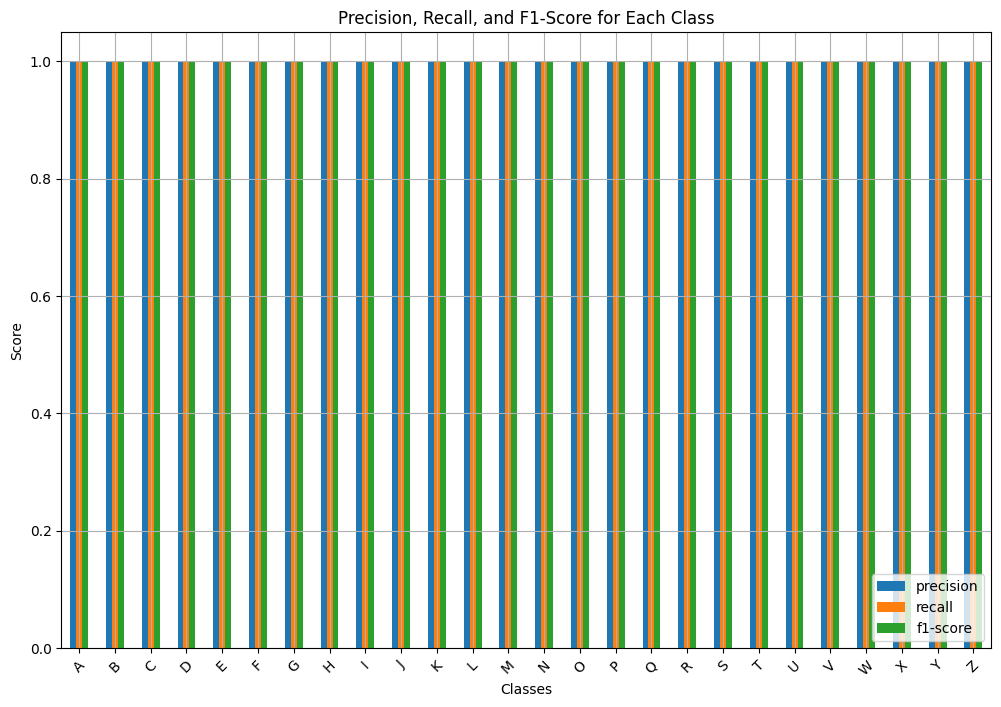

In [21]:
# Plot Precision, Recall, and F1-Score
metrics = ['precision', 'recall', 'f1-score']
df_metrics[metrics].plot(kind='bar', figsize=(12, 8))
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('my_plot1.png', dpi=300, bbox_inches='tight')
plt.show()


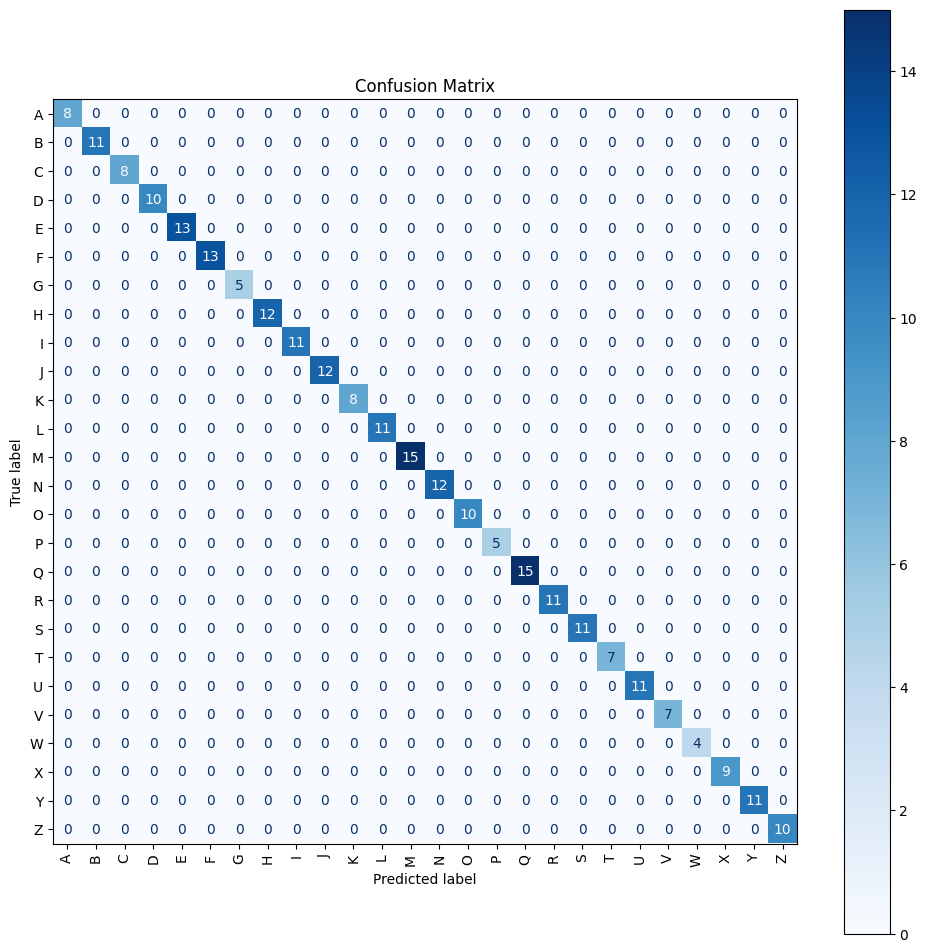

In [22]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=actions)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix1.png', dpi=300, bbox_inches='tight')
plt.show()

### Real Time Detection Begin:

In [30]:

# Update the preprocess_frame function
def preprocess_frame(results):
    # Extract keypoints
    keypoints = extract_keypoints(results)
    # Reshape to (1, keypoints)
    keypoints = keypoints.reshape(1, -1)
    # Normalize keypoints
    keypoints = normalize_keypoints(keypoints)
    return keypoints[0]

In [31]:
colors = [
    (255, 0, 0),      # A
    (0, 255, 0),      # B
    (0, 0, 255),      # C
    (255, 255, 0),    # D
    (0, 255, 255),    # E
    (255, 0, 255),    # F
    (190, 125, 0),    # G
    (0, 190, 125),    # H
    (190, 0, 125),    # I
    (25, 185, 0),     # J
    (0, 25, 185),     # K
    (185, 0, 25),     # L
    (100, 0, 100),    # M
    (0, 100, 100),    # N
    (123, 123, 0),    # O
    (255, 165, 0),    # P
    (75, 0, 130),     # Q
    (255, 20, 147),   # R
    (0, 128, 0),      # S
    (128, 0, 128),    # T
    (0, 0, 128),      # U
    (128, 128, 0),    # V
    (0, 100, 200),    # W
    (28, 20, 50),   # X
    (85, 100, 128),   # Y
    (70, 75, 75)   # Z
]


In [32]:
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    
    # Get the dimensions of the window
    frame_height, frame_width, _ = output_frame.shape
    
    # Set configuration for dynamic layout
    left_column_letters = 13  # Adjusted number of letters on the left side
    top_row_letters = 0       # No letters on the top side
    label_height = 30         # Vertical spacing for left and right
    label_width = 120         # Maximum width of rectangles for probability bars
    top_spacing = 40          # Adjustable spacing for top row
    top_letter_spacing = 5    # Adjustable spacing between top letters

    # Iterate over the results and position letters accordingly
    for num, prob in enumerate(res):
        if num < left_column_letters:
            # Left-side placement
            x_offset = 0
            y_position = top_spacing + num * label_height
            # Probability bars increasing to the right
            cv2.rectangle(output_frame, (x_offset, y_position), 
                          (x_offset + int(prob * 100), y_position + 20), 
                          colors[num % len(colors)], -1)
            cv2.putText(output_frame, actions[num], (x_offset, y_position + 15), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

        else:
            # Right-side placement
            x_offset = frame_width - label_width  # Adjust the starting point to be near the edge
            y_position = top_spacing + (num - left_column_letters) * label_height
            # Probability bars increasing to the left
            bar_start = x_offset + label_width - int(prob * 100)
            cv2.rectangle(output_frame, 
                          (bar_start, y_position),
                          (x_offset + label_width, y_position + 20), 
                          colors[num % len(colors)], -1)
            cv2.putText(output_frame, actions[num], 
                        (bar_start - 20, y_position + 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    
    return output_frame

In [59]:
# New Detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.7

# Load your trained model
model = tf.keras.models.load_model('best_model.keras')  # Ensure 'best_model.keras' is your trained model

cap = cv2.VideoCapture(0)

# Access MediaPipe model
with mp_holistic.Holistic(
    min_detection_confidence=0.5, 
    min_tracking_confidence=0.5,
    model_complexity=0,  # Simplify the model since we're only using hand landmarks
) as holistic:
    while cap.isOpened():
        # Read the feed
        ret, frame = cap.read()

        if not ret:
            print("Ignoring empty camera frame.")
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        # print(results)  # Uncomment to see the detection results

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Preprocess the frame
        keypoints = preprocess_frame(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]  # Keep only the last 30 frames

        # Once we have 30 frames, make a prediction
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))

            # Visualize results if the prediction is consistent
            if np.unique(predictions[-10:])[0] == np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

                if len(sentence) > 5:
                    sentence = sentence[-5:]

            # Show probability visualization
            image = prob_viz(res, actions, image, colors)

        # Display the result
        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show to the screen
        cv2.imshow('Frame', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
H

### Video Recording Function with Real Time Detection

In [60]:
# New Detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.7

# Load your trained model
model = tf.keras.models.load_model('best_model.keras')  # Ensure 'best_model.keras' is your trained model

cap = cv2.VideoCapture(0) # Use the OBS Virtual Camera as the input

# Get frame width and height (required for VideoWriter)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can use other codecs like 'MJPG', 'XVID', 'MP4V', etc.
out = cv2.VideoWriter('best_output.avi', fourcc, 20.0, (frame_width, frame_height))

# Access MediaPipe model
with mp_holistic.Holistic(
    min_detection_confidence=0.5, 
    min_tracking_confidence=0.5,
    model_complexity=0,  # Simplify the model since we're only using hand landmarks
) as holistic:
    while cap.isOpened():
        # Read the feed
        ret, frame = cap.read()

        if not ret:
            print("Ignoring empty camera frame.")
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        # print(results)  # Uncomment to see the detection results

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Preprocess the frame
        keypoints = preprocess_frame(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]  # Keep only the last 30 frames

        # Once we have 30 frames, make a prediction
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))

            # Visualize results if the prediction is consistent
            if np.unique(predictions[-10:])[0] == np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

                if len(sentence) > 5:
                    sentence = sentence[-5:]

            # Show probability visualization
            image = prob_viz(res, actions, image, colors)

        # Display the result
        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Write the frame into the file 'output.avi'
        out.write(image)

        # Show to the screen
        cv2.imshow('Frame', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    # Release everything when job is finished
    cap.release()
    out.release()
    cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
B
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
B
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
A

### Video with High Quality

In [58]:
# New Detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.7

# Load your trained model
model = tf.keras.models.load_model('best_model.keras')  # Ensure 'best_model.keras' is your trained model

# Open the camera feed (use OBS Virtual Camera if set up)
cap = cv2.VideoCapture(0)

# Set the resolution to the highest supported by the camera
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)  # Try setting to 1920x1080 (Full HD)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)  # Full HD resolution
cap.set(cv2.CAP_PROP_FPS, 10)  # Set to 30 FPS or higher if supported

# Get frame width and height for VideoWriter
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))  # Capture at the highest FPS available

# Define the codec and create VideoWriter object for high-quality output
fourcc = cv2.VideoWriter_fourcc(*'MP4V')  # Use 'MP4V' for better quality and compression
out = cv2.VideoWriter('high_quality_output.mp4', fourcc, fps, (frame_width, frame_height))

# Access MediaPipe model
with mp_holistic.Holistic(
    min_detection_confidence=0.5, 
    min_tracking_confidence=0.5,
    model_complexity=0,  # Simplify the model for faster detection
) as holistic:
    while cap.isOpened():
        # Read the feed
        ret, frame = cap.read()

        if not ret:
            print("Ignoring empty camera frame.")
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Preprocess the frame for the model
        keypoints = preprocess_frame(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]  # Keep only the last 30 frames

        # Once we have 30 frames, make a prediction
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))

            # Visualize results if the prediction is consistent
            if np.unique(predictions[-10:])[0] == np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

                if len(sentence) > 5:
                    sentence = sentence[-5:]

            # Show probability visualization
            image = prob_viz(res, actions, image, colors)

        # Display the result
        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Write the frame into the file 'high_quality_output.mp4'
        out.write(image)

        # Show the frame on screen
        cv2.imshow('Frame', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    # Release everything when the job is finished
    cap.release()
    out.release()
    cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
B
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
A

In [43]:
cap.release()
out.release()
cv2.destroyAllWindows()